# Examining the 100-year storm
### From past analysis, we've seen that there have been 3 100-year storms in the last 46 years.  This notebook takes a look at these 3 storms.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import operator
import seaborn as sns
%matplotlib inline

In [2]:
n_year_storms = pd.read_csv('data/n_year_storms_ohare_noaa.csv')
n_year_storms['start_time'] = pd.to_datetime(n_year_storms['start_time'])
n_year_storms['end_time'] = pd.to_datetime(n_year_storms['end_time'])
n_year_storms.head()

,n,duration_hrs,start_time,end_time,inches,year
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55,1987
1,100,240,2008-09-04 13:00:00,2008-09-14 13:00:00,11.94,2008
2,100,24,2011-07-22 08:00:00,2011-07-23 08:00:00,7.86,2011
3,50,24,2010-07-23 16:00:00,2010-07-24 16:00:00,6.54,2010
4,50,3,2001-08-30 21:00:00,2001-08-31 00:00:00,4.27,2001


In [3]:
year_event_100 = n_year_storms[n_year_storms['n'] == 100]
year_event_100

,n,duration_hrs,start_time,end_time,inches,year
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55,1987
1,100,240,2008-09-04 13:00:00,2008-09-14 13:00:00,11.94,2008
2,100,24,2011-07-22 08:00:00,2011-07-23 08:00:00,7.86,2011


In [4]:
rain_df = pd.read_csv('data/ohare_hourly_20160929.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
rain_df = rain_df['19700101':]
chi_rain_series = rain_df['HOURLYPrecip'].resample('1H', label='right').max().fillna(0)
chi_rain_series.head()

1970-01-01 04:00:00    0.0
1970-01-01 05:00:00    0.0
1970-01-01 06:00:00    0.0
1970-01-01 07:00:00    0.0
1970-01-01 08:00:00    0.0
Freq: H, Name: HOURLYPrecip, dtype: float64

In [5]:
# N-Year Storm variables
# These define the thresholds laid out by bulletin 70, and transfer mins and days to hours
n_year_threshes = pd.read_csv('../../n-year/notebooks/data/n_year_definitions.csv')
n_year_threshes = n_year_threshes.set_index('Duration')
dur_str_to_hours = {
    '5-min':5/60.0,
    '10-min':10/60.0,
    '15-min':15/60.0,
    '30-min':0.5,
    '1-hr':1.0,
    '2-hr':2.0,
    '3-hr':3.0,
    '6-hr':6.0,
    '12-hr':12.0,
    '18-hr':18.0,
    '24-hr':24.0,
    '48-hr':48.0,
    '72-hr':72.0,
    '5-day':5*24.0,
    '10-day':10*24.0
}
n_s = [int(x.replace('-year','')) for x in reversed(list(n_year_threshes.columns.values))]
duration_strs = sorted(dur_str_to_hours.items(), key=operator.itemgetter(1), reverse=False)
n_year_threshes

,1-year,2-year,5-year,10-year,25-year,50-year,100-year
Duration,,,,,,,
10-day,4.12,4.95,6.04,6.89,8.18,9.38,11.14
5-day,3.25,3.93,4.91,5.70,6.93,8.04,9.96
72-hr,2.93,3.55,4.44,5.18,6.32,7.41,8.78
48-hr,2.70,3.30,4.09,4.81,5.88,6.84,8.16
24-hr,2.51,3.04,3.80,4.47,5.51,6.46,7.58
18-hr,2.30,2.79,3.50,4.11,5.06,5.95,6.97
12-hr,2.18,2.64,3.31,3.89,4.79,5.62,6.59
6-hr,1.88,2.28,2.85,3.35,4.13,4.85,5.68
3-hr,1.60,1.94,2.43,2.86,3.53,4.14,4.85


In [6]:
# Find n-year storms and store them in a data frame.
def find_n_year_storms(start_time_str, end_time_str, n):
    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    n_index = n_s.index(n)
    next_n = n_s[n_index-1] if n_index != 0 else None
    storms = []

    for duration_tuple in duration_strs:

        duration_str = duration_tuple[0]
        low_thresh = n_year_threshes.loc[duration_str, str(n) + '-year']
        high_thresh = n_year_threshes.loc[duration_str, str(next_n) + '-year'] if next_n is not None else None
        
        duration = int(dur_str_to_hours[duration_str])
        sub_series = chi_rain_series[start_time: end_time]
        rolling = sub_series.rolling(window=int(duration), min_periods=0).sum()
        
        if high_thresh is not None:
            event_endtimes = rolling[(rolling >= low_thresh) & (rolling < high_thresh)].sort_values(ascending=False)
        else:
            event_endtimes = rolling[(rolling >= low_thresh)].sort_values(ascending=False)
        for index, event_endtime in event_endtimes.iteritems():
            this_start_time = index - timedelta(hours=duration)
            if this_start_time < start_time:
                continue
            storms.append({'n': n, 'end_time': index, 'inches': event_endtime, 'duration_hrs': duration,
                          'start_time': this_start_time})
    return pd.DataFrame(storms)

## Storm 1 -> August, 1987

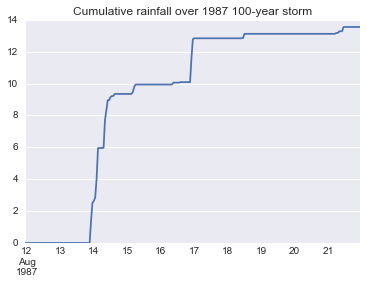

In [7]:
storm1 = chi_rain_series['1987-08-11 23:00:00':'1987-08-21 23:00:00']
storm1.cumsum().plot(title="Cumulative rainfall over 1987 100-year storm")

In [8]:
# The rainfall starts at...
storm1[storm1 > 0].index[0]

Timestamp('1987-08-13 22:00:00')

In [9]:
storm1 = storm1['1987-08-13 22:00:00':]
storm1.head()

1987-08-13 22:00:00    1.36
1987-08-13 23:00:00    1.15
1987-08-14 00:00:00    0.12
1987-08-14 01:00:00    0.23
1987-08-14 02:00:00    1.15
Freq: H, Name: HOURLYPrecip, dtype: float64

In [10]:
# There are two periods of drastic rise in rain.  Print out the percent of the storm that has fallen hourly to see that the
# first burst ends at 8/14 10AM
storm1.cumsum()/storm1.sum()

1987-08-13 22:00:00    0.100369
1987-08-13 23:00:00    0.185240
1987-08-14 00:00:00    0.194096
1987-08-14 01:00:00    0.211070
1987-08-14 02:00:00    0.295941
1987-08-14 03:00:00    0.439114
1987-08-14 04:00:00    0.439852
1987-08-14 05:00:00    0.439852
1987-08-14 06:00:00    0.439852
1987-08-14 07:00:00    0.440590
1987-08-14 08:00:00    0.568266
1987-08-14 09:00:00    0.616236
1987-08-14 10:00:00    0.661255
1987-08-14 11:00:00    0.661255
1987-08-14 12:00:00    0.676015
1987-08-14 13:00:00    0.680443
1987-08-14 14:00:00    0.680443
1987-08-14 15:00:00    0.690037
1987-08-14 16:00:00    0.690037
1987-08-14 17:00:00    0.690037
1987-08-14 18:00:00    0.690037
1987-08-14 19:00:00    0.690037
1987-08-14 20:00:00    0.690037
1987-08-14 21:00:00    0.690037
1987-08-14 22:00:00    0.690037
1987-08-14 23:00:00    0.690037
1987-08-15 00:00:00    0.690037
1987-08-15 01:00:00    0.690037
1987-08-15 02:00:00    0.690037
1987-08-15 03:00:00    0.690037
                         ...   
1987-08-

In [11]:
# Looking for an n-year storm in the small period of drastic increase #1
find_n_year_storms('1987-08-13 22:00:00', '1987-08-14 10:00:00', 100)

,duration_hrs,end_time,inches,n,start_time
0,12,1987-08-14 10:00:00,7.6,100,1987-08-13 22:00:00


In [12]:
# Let's look for the second jump in precip
storm1['1987-08-16 12:00:00':].cumsum()/storm1.sum()

1987-08-16 12:00:00    0.000000
1987-08-16 13:00:00    0.000000
1987-08-16 14:00:00    0.002214
1987-08-16 15:00:00    0.002214
1987-08-16 16:00:00    0.002214
1987-08-16 17:00:00    0.002214
1987-08-16 18:00:00    0.002214
1987-08-16 19:00:00    0.002214
1987-08-16 20:00:00    0.002214
1987-08-16 21:00:00    0.002214
1987-08-16 22:00:00    0.112915
1987-08-16 23:00:00    0.201476
1987-08-17 00:00:00    0.205166
1987-08-17 01:00:00    0.205166
1987-08-17 02:00:00    0.205166
1987-08-17 03:00:00    0.205166
1987-08-17 04:00:00    0.205166
1987-08-17 05:00:00    0.205166
1987-08-17 06:00:00    0.205166
1987-08-17 07:00:00    0.205166
1987-08-17 08:00:00    0.205166
1987-08-17 09:00:00    0.205166
1987-08-17 10:00:00    0.205166
1987-08-17 11:00:00    0.205166
1987-08-17 12:00:00    0.205166
1987-08-17 13:00:00    0.205166
1987-08-17 14:00:00    0.205166
1987-08-17 15:00:00    0.205166
1987-08-17 16:00:00    0.205166
1987-08-17 17:00:00    0.205166
                         ...   
1987-08-

In [71]:
# Looking for an n-year storm in the small period of drastic increase #2
find_n_year_storms('1987-08-16 20:00:00', '1987-08-17 00:00:00', 10)

,duration_hrs,end_time,inches,n,start_time
0,2,1987-08-16 23:00:00,2.7,10,1987-08-16 21:00:00


### Looking at Storm 1 we see that within the 100-year storm, the real bulk of the rainfall falls overnight Aug 13-14 from 10PM until 10AM.  This in itself was a 100-year storm.  A few days later, we had an additional equivalent of a 10-year storm -- all this within the same 10 day period

# Storm 2 -> September 2008

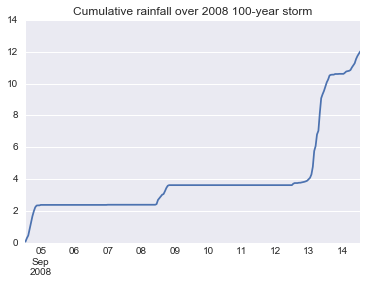

In [14]:
storm2 = chi_rain_series['2008-09-04 13:00:00':'2008-09-14 13:00:00']
storm2.cumsum().plot(title="Cumulative rainfall over 2008 100-year storm")

#### This event has 3 big downpours.  Let's split this up

In [16]:
total_rainfall = storm2.sum()
total_rainfall

12.020000000000001

In [17]:
storm2.cumsum()/total_rainfall

2008-09-04 13:00:00    0.006656
2008-09-04 14:00:00    0.024958
2008-09-04 15:00:00    0.039101
2008-09-04 16:00:00    0.073211
2008-09-04 17:00:00    0.108985
2008-09-04 18:00:00    0.139767
2008-09-04 19:00:00    0.165557
2008-09-04 20:00:00    0.186356
2008-09-04 21:00:00    0.195507
2008-09-04 22:00:00    0.196339
2008-09-04 23:00:00    0.196339
2008-09-05 00:00:00    0.198835
2008-09-05 01:00:00    0.198835
2008-09-05 02:00:00    0.198835
2008-09-05 03:00:00    0.198835
2008-09-05 04:00:00    0.198835
2008-09-05 05:00:00    0.198835
2008-09-05 06:00:00    0.198835
2008-09-05 07:00:00    0.198835
2008-09-05 08:00:00    0.198835
2008-09-05 09:00:00    0.198835
2008-09-05 10:00:00    0.198835
2008-09-05 11:00:00    0.198835
2008-09-05 12:00:00    0.198835
2008-09-05 13:00:00    0.198835
2008-09-05 14:00:00    0.198835
2008-09-05 15:00:00    0.198835
2008-09-05 16:00:00    0.198835
2008-09-05 17:00:00    0.198835
2008-09-05 18:00:00    0.198835
                         ...   
2008-09-

In [26]:
# First downpour is a 1-year storm
find_n_year_storms('2008-09-04 13:00:00', '2008-09-04 21:00:00', 1)

,duration_hrs,end_time,inches,n,start_time
0,6,2008-09-04 20:00:00,1.94,1,2008-09-04 14:00:00
1,6,2008-09-04 19:00:00,1.91,1,2008-09-04 13:00:00
2,6,2008-09-04 21:00:00,1.88,1,2008-09-04 15:00:00


In [29]:
storm2['2008-09-08 00:00:00':'2008-09-09 00:00:00'].cumsum()/total_rainfall

2008-09-08 00:00:00    0.000000
2008-09-08 01:00:00    0.000000
2008-09-08 02:00:00    0.000000
2008-09-08 03:00:00    0.000000
2008-09-08 04:00:00    0.000000
2008-09-08 05:00:00    0.000000
2008-09-08 06:00:00    0.000000
2008-09-08 07:00:00    0.000000
2008-09-08 08:00:00    0.000000
2008-09-08 09:00:00    0.000000
2008-09-08 10:00:00    0.000000
2008-09-08 11:00:00    0.003328
2008-09-08 12:00:00    0.024958
2008-09-08 13:00:00    0.034110
2008-09-08 14:00:00    0.043261
2008-09-08 15:00:00    0.052413
2008-09-08 16:00:00    0.055740
2008-09-08 17:00:00    0.070715
2008-09-08 18:00:00    0.087354
2008-09-08 19:00:00    0.099002
2008-09-08 20:00:00    0.102329
2008-09-08 21:00:00    0.102329
2008-09-08 22:00:00    0.102329
2008-09-08 23:00:00    0.102329
2008-09-09 00:00:00    0.102329
Freq: H, Name: HOURLYPrecip, dtype: float64

In [37]:
find_n_year_storms('2008-09-08 10:00:00', '2008-09-08 20:00:00', 1)

""


In [38]:
chi_rain_series['2008-09-08 10:00:00':'2008-09-08 20:00:00'].sum()

1.23

In [39]:
# No n-year events for second downpour

In [41]:
# Downpour 3
storm2['2008-09-12 12:00:00':'2008-09-13 15:00:00'].cumsum()/total_rainfall

2008-09-12 12:00:00    0.000000
2008-09-12 13:00:00    0.007488
2008-09-12 14:00:00    0.010815
2008-09-12 15:00:00    0.010815
2008-09-12 16:00:00    0.010815
2008-09-12 17:00:00    0.012479
2008-09-12 18:00:00    0.012479
2008-09-12 19:00:00    0.014143
2008-09-12 20:00:00    0.015807
2008-09-12 21:00:00    0.017471
2008-09-12 22:00:00    0.019967
2008-09-12 23:00:00    0.023295
2008-09-13 00:00:00    0.030782
2008-09-13 01:00:00    0.038270
2008-09-13 02:00:00    0.055740
2008-09-13 03:00:00    0.095674
2008-09-13 04:00:00    0.178037
2008-09-13 05:00:00    0.203827
2008-09-13 06:00:00    0.264559
2008-09-13 07:00:00    0.283694
2008-09-13 08:00:00    0.375208
2008-09-13 09:00:00    0.453411
2008-09-13 10:00:00    0.474210
2008-09-13 11:00:00    0.491681
2008-09-13 12:00:00    0.514975
2008-09-13 13:00:00    0.536606
2008-09-13 14:00:00    0.551581
2008-09-13 15:00:00    0.572379
Freq: H, Name: HOURLYPrecip, dtype: float64

In [45]:
find_n_year_storms('2008-09-12 12:00:00','2008-09-13 15:00:00',50)

,duration_hrs,end_time,inches,n,start_time
0,12,2008-09-13 13:00:00,5.99,50,2008-09-13 01:00:00
1,12,2008-09-13 14:00:00,5.96,50,2008-09-13 02:00:00
2,12,2008-09-13 12:00:00,5.82,50,2008-09-13 00:00:00
3,12,2008-09-13 15:00:00,5.73,50,2008-09-13 03:00:00
4,12,2008-09-13 11:00:00,5.63,50,2008-09-12 23:00:00
5,18,2008-09-13 15:00:00,6.67,50,2008-09-12 21:00:00
6,18,2008-09-13 14:00:00,6.44,50,2008-09-12 20:00:00
7,18,2008-09-13 13:00:00,6.28,50,2008-09-12 19:00:00
8,18,2008-09-13 12:00:00,6.04,50,2008-09-12 18:00:00
9,24,2008-09-13 15:00:00,6.75,50,2008-09-12 15:00:00


# Storm 3 - July 2011

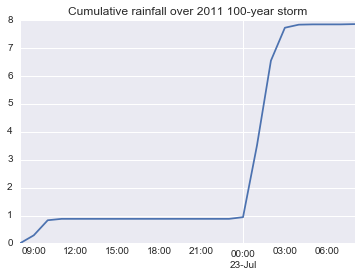

In [48]:
storm3 = chi_rain_series['2011-07-22 08:00:00':'2011-07-23 08:00:00']
storm3.cumsum().plot(title="Cumulative rainfall over 2011 100-year storm")

In [49]:
storm3['2011-07-22 22:00:00':'2011-07-23 05:00:00'].cumsum()/storm3.sum()

2011-07-22 22:00:00    0.000000
2011-07-22 23:00:00    0.000000
2011-07-23 00:00:00    0.007634
2011-07-23 01:00:00    0.334606
2011-07-23 02:00:00    0.721374
2011-07-23 03:00:00    0.871501
2011-07-23 04:00:00    0.885496
2011-07-23 05:00:00    0.886768
Freq: H, Name: HOURLYPrecip, dtype: float64

In [50]:
find_n_year_storms('2011-07-22 22:00:00', '2011-07-23 05:00:00', 100)

,duration_hrs,end_time,inches,n,start_time
0,2,2011-07-23 02:00:00,5.61,100,2011-07-23 00:00:00
1,3,2011-07-23 03:00:00,6.79,100,2011-07-23 00:00:00
2,3,2011-07-23 02:00:00,5.67,100,2011-07-22 23:00:00
3,6,2011-07-23 05:00:00,6.97,100,2011-07-22 23:00:00
4,6,2011-07-23 04:00:00,6.96,100,2011-07-22 22:00:00


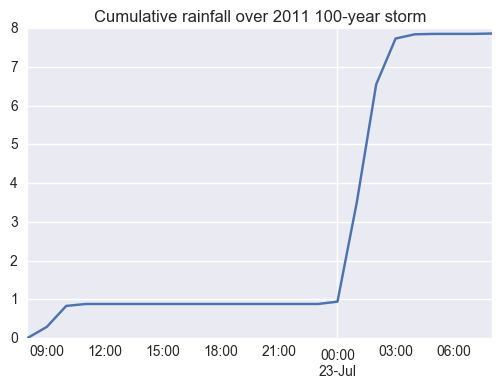

In [17]:
chi_rain_series['2011-07-22 08:00:00':'2011-07-23 08:00:00'].cumsum().plot(title="Cumulative rainfall over 2011 100-year storm")

## Interestingly, all of the 100-year storms are marked with a drastic period of a few hours which really makes it the big one.

### Let's examine the 50-years to look for the same trend

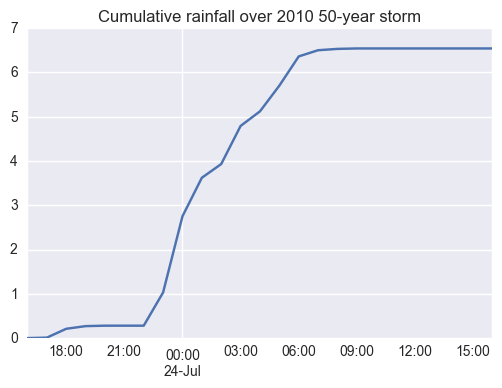

In [18]:
chi_rain_series['2010-07-23 16:00:00':'2010-07-24 16:00:00'].cumsum().plot(title="Cumulative rainfall over 2010 50-year storm")

In [2]:
# The following code is copied verbatim from @pjsier Rolling Rain N-Year Threshold.pynb
# Loading in hourly rain data from CSV, parsing the timestamp, and adding it as an index so it's more useful

rain_df = pd.read_csv('data/ohare_hourly_observations.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
print(rain_df.dtypes)
rain_df.head()

Unnamed: 0                          int64
datetime                   datetime64[ns]
dewpoint_fahrenheit               float64
drybulb_fahrenheit                float64
hourly_precip                     float64
id                                  int64
latitude                          float64
longitude                         float64
old_station_type                   object
relative_humidity                 float64
report_type                        object
sealevel_pressure                 float64
sky_condition                      object
sky_condition_top                  object
station_pressure                  float64
station_type                      float64
visibility                        float64
wban_code                           int64
weather_types                      object
wetbulb_fahrenheit                float64
wind_direction                     object
wind_direction_cardinal            object
wind_speed                        float64
call_sign                         

d:\data_science_projects\chicagorain\virtualenvs\nyear-venv\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,datetime,dewpoint_fahrenheit,drybulb_fahrenheit,hourly_precip,id,latitude,longitude,old_station_type,relative_humidity,...,station_pressure,station_type,visibility,wban_code,weather_types,wetbulb_fahrenheit,wind_direction,wind_direction_cardinal,wind_speed,call_sign
2016-08-16 22:51:00,0,2016-08-16 22:51:00,65.0,74.0,0.0,398063571,NaN,NaN,NaN,74.0,...,29.37,11.0,10.0,94846,NaN,68.0,200,SSW,7.0,KORD
2016-08-16 21:51:00,1,2016-08-16 21:51:00,64.0,74.0,0.0,397933331,NaN,NaN,NaN,71.0,...,29.36,11.0,10.0,94846,NaN,68.0,200,SSW,5.0,KORD
2016-08-16 20:51:00,2,2016-08-16 20:51:00,64.0,76.0,0.0,397986035,NaN,NaN,NaN,67.0,...,29.35,11.0,10.0,94846,NaN,68.0,220,SW,3.0,KORD
2016-08-16 19:51:00,3,2016-08-16 19:51:00,64.0,78.0,0.0,398003060,NaN,NaN,NaN,62.0,...,29.34,11.0,10.0,94846,NaN,69.0,NaN,NaN,0.0,KORD
2016-08-16 18:51:00,4,2016-08-16 18:51:00,65.0,76.0,0.0,397972638,NaN,NaN,NaN,69.0,...,29.32,11.0,10.0,94846,NaN,69.0,160,SSE,6.0,KORD


In [3]:
chi_rain_series = rain_df['hourly_precip'].resample('1H').max()

In [4]:
# This is where I break with @pjsier

In [5]:
# I am assuming here that a single hour cannot be part of more than one storm in the event_endtimes list.
# Therefore, I am looping through the list and throwing out any storms that include hours from heavier storms in the
# same block of time.=
def get_storms_without_overlap(event_endtimes, hours):
    times_taken = []
    ret_val = []
    for i in range(len(event_endtimes)):
        timestamp = event_endtimes.iloc[i].name
        times_here = []
        for h in range(hours):
            times_here.append(timestamp - pd.DateOffset(hours=h))
        if not bool(set(times_here) & set(times_taken)):
            times_taken.extend(times_here)
            ret_val.append({'start': timestamp - pd.DateOffset(hours=hours), 'end': timestamp, 'inches': event_endtimes.iloc[i]['hourly_precip']})
    return ret_val

In [6]:
# Find the 100 year event.  First, define the storm as based in Illinois Bulletin 70 as the number of inches
# of precipition that falls over a given span of straight hours.
_100_year_storm_milestones = [{'hours': 240, 'inches': 11.14}, {'hours':120, 'inches': 9.96},
                              {'hours': 72, 'inches': 8.78}, {'hours': 48, 'inches': 8.16}, {'hours': 24, 'inches': 7.58},
                             {'hours': 18, 'inches': 6.97}, {'hours': 12, 'inches': 6.59}, {'hours': 6, 'inches': 5.68},
                             {'hours': 3, 'inches': 4.9}, {'hours': 2, 'inches': 4.47}, {'hours': 1, 'inches': 3.51}]
all_storms = []
print("\tSTART\t\t\tEND\t\t\tINCHES")
for storm_hours in _100_year_storm_milestones:
    rolling = pd.DataFrame(chi_rain_series.rolling(window=storm_hours['hours']).sum())
    event_endtimes = rolling[(rolling['hourly_precip'] >= storm_hours['inches'])]
    event_endtimes = event_endtimes.sort_values(by='hourly_precip', ascending=False)
    storms = get_storms_without_overlap(event_endtimes, storm_hours['hours'])

    if len(storms) > 0:
        print("Across %s hours" % storm_hours['hours'])
        for storm in storms:
            print('\t%s\t%s\t%s inches' % (storm['start'], storm['end'], storm['inches']))
        all_storms.extend(storms)

	START			END			INCHES
Across 240 hours
	2015-01-25 02:00:00	2015-02-04 02:00:00	13.765 inches
	2008-09-04 12:00:00	2008-09-14 12:00:00	12.06 inches
Across 120 hours
	2015-01-30 18:00:00	2015-02-04 18:00:00	13.515 inches
Across 72 hours
	2015-01-31 18:00:00	2015-02-03 18:00:00	13.48 inches
Across 48 hours
	2015-01-31 11:00:00	2015-02-02 11:00:00	13.385 inches
	2011-07-21 12:00:00	2011-07-23 12:00:00	8.45 inches
	2008-09-12 14:00:00	2008-09-14 14:00:00	8.365 inches
Across 24 hours
	2015-02-01 10:00:00	2015-02-02 10:00:00	12.78 inches
	2011-07-22 07:00:00	2011-07-23 07:00:00	8.22 inches
Across 18 hours
	2015-02-01 16:00:00	2015-02-02 10:00:00	12.375 inches
	2011-07-22 08:00:00	2011-07-23 02:00:00	7.29 inches
Across 12 hours
	2015-02-01 22:00:00	2015-02-02 10:00:00	10.42 inches
	2011-07-22 22:00:00	2011-07-23 10:00:00	6.935 inches
Across 6 hours
	2015-02-02 04:00:00	2015-02-02 10:00:00	9.655 inches
	2011-07-22 22:00:00	2011-07-23 04:00:00	6.915 inches
Across 3 hours
	2015-02-02 07:00:00	20

In [7]:
# Analysis Questions
# 1/25/2015 - 2/4/2015 - Worst storm by far in quantity, but Jan-Feb -- is it snow?
# 9/4/2008 - 9/14/2008 - This only appeared on the 10-day event, so it must've been well distributed across the days?
# 7/21/2011 - 7/23/2011 - Very heavy summer storm!

In [8]:
# Examining the storm from 7/21-2011 - 7/23/2011
import datetime
july_2011_storm = chi_rain_series.loc[(chi_rain_series.index >= datetime.datetime(2011,7,20)) & (chi_rain_series.index <= datetime.datetime(2011,7,24))]
july_2011_storm.head()

2011-07-20 00:00:00    0.00
2011-07-20 01:00:00    0.00
2011-07-20 02:00:00    0.02
2011-07-20 03:00:00    0.00
2011-07-20 04:00:00    0.00
Freq: H, Name: hourly_precip, dtype: float64

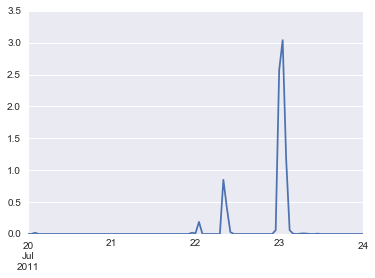

In [9]:
july_2011_storm.plot()

In [10]:
# Let's take a look at the cumulative buildup of the storm over time
cumulative_rainj11 = pd.DataFrame(july_2011_storm).hourly_precip.cumsum()
cumulative_rainj11.head()

2011-07-20 00:00:00    0.00
2011-07-20 01:00:00    0.00
2011-07-20 02:00:00    0.02
2011-07-20 03:00:00    0.02
2011-07-20 04:00:00    0.02
Freq: H, Name: hourly_precip, dtype: float64

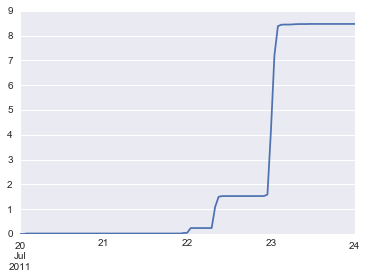

In [11]:
cumulative_rainj11.plot()

In [12]:
cumulative_rainj11.loc[(cumulative_rainj11.index >= datetime.datetime(2011,7,22,21,0,0)) & (cumulative_rainj11.index <= datetime.datetime(2011,7,23,5,0,0))]

2011-07-22 21:00:00    1.530
2011-07-22 22:00:00    1.530
2011-07-22 23:00:00    1.590
2011-07-23 00:00:00    4.160
2011-07-23 01:00:00    7.200
2011-07-23 02:00:00    8.380
2011-07-23 03:00:00    8.440
2011-07-23 04:00:00    8.445
2011-07-23 05:00:00    8.445
Freq: H, Name: hourly_precip, dtype: float64

In [13]:
# We got a crazy, crazy downpour from about 11:00PM until 2:00AM.  That alone was a 100-year storm, where we got 6.79 inches
# in 3 hours.  That would've been a 100-year storm if we'd have gotten that in 12 hours!